# SWMAL Demo

## Keras setup and train on MNIST data

In [1]:
import numpy as np
from libitmal import dataloaders 

X, y = dataloaders.MNIST_GetDataSet()

X = X.reshape(70000, 784)
#X_norm = X*np.float32(1)  # NOTE: ups, remembered convert to float but forgot scale 
X_norm = X/np.float32(255) # NOTE: remembered convert to float and scale 

print(f"X_norm.shape={X_norm.shape}")
print(f"  type(X_norm[0][0])={type(X_norm[0][0])}")
print(f"  X_norm.dtype={X_norm.dtype}")
print(f"  np.max(X_norm)={np.max(X_norm)}")
print(f"  np.min(X_norm)={np.min(X_norm)}")

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3, random_state=42)

y_train_cat = to_categorical(y_train)
y_test_cat  = to_categorical(y_test)

X_norm.shape=(70000, 784)
  type(X_norm[0][0])=<class 'numpy.float32'>
  X_norm.dtype=float32
  np.max(X_norm)=1.0
  np.min(X_norm)=0.0


In [2]:
from time import time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, Nadam
#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras.backend import batch_normalization

def AddLayer(model, units, add_normalization=False, dropout_rate=-1):
    model.add(Dense(units=units, 
                activation="elu", 
                kernel_initializer="he_normal",  
                bias_initializer  ="he_normal"))     
    if add_normalization:
        model.add(BatchNormalization())
    if dropout_rate>=0:
        model.add(Dropout(rate=dropout_rate))


model = Sequential()
#model.add(BatchNormalization())
model.add(Dense(input_dim=(784), units=20, 
                activation="elu", 
                kernel_initializer="he_normal",  
                bias_initializer  ="he_normal"))     
#model.add(BatchNormalization())
#model.add(Dropout(rate=DROPOUT_RATE))

AddLayer(model, 50)
AddLayer(model, 70)
AddLayer(model, 100)
AddLayer(model, 70)
AddLayer(model, 50)
AddLayer(model, 20)

model.add(Dense(units=10, 
                activation="softmax",
                kernel_initializer="he_normal",  
                bias_initializer  ="he_normal"))     

def ModelCompile(model):
    #optimizer = Adam (learning_rate=0.1) # NOTE: will fail miserable for learning_rate=0.1
    #optimizer = Adam (learning_rate=0.01) 
    #optimizer = Nadam(learning_rate=0.002) # NOTE: Nadam=Nesterov Adam optimizer.
    optimizer = SGD  (learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
          
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                   metrics=['categorical_crossentropy',
                            'categorical_accuracy',
                            'mean_squared_error',
                            'mean_absolute_error'])
    try:
        model.summary()
    except:
        print("WARNING: model.summary() failed, cannot print models with BatchNormalization() layers before fit")
    

def PrintScore(model, X_test, y_test_cat, t):
    #print(history.history)
    score = model.evaluate(X_test, y_test_cat, verbose=0)
    print(f"Training time: {t:0.1f} sec")
    print(f"Test loss:     {score[0]}") # loss is score 0 by definition?
    print(f"Test accuracy: {score[2]}")
    #print(f"All scores in history: {score}")
    
# Train
VERBOSE     = 1
EPOCHS      = 20
DROPOUT_RATE= 0.1

ModelCompile(model)

start = time()
history = model.fit(X_train, y_train_cat, 
                    validation_data=(X_test, y_test_cat), 
                    epochs=EPOCHS, 
                    verbose=VERBOSE)
t = time()-start

print("")
PrintScore(model, X_test, y_test_cat, t)
print("\nOK")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                15700     
                                                                 
 dense_1 (Dense)             (None, 50)                1050      
                                                                 
 dense_2 (Dense)             (None, 70)                3570      
                                                                 
 dense_3 (Dense)             (None, 100)               7100      
                                                                 
 dense_4 (Dense)             (None, 70)                7070      
                                                                 
 dense_5 (Dense)             (None, 50)                3550      
                                                                 
 dense_6 (Dense)             (None, 20)                1

2023-10-03 10:23:13.148408: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: .:/opt/cuda-11.2/lib64:/opt/opencv/opencv4-4.5.1/lib:/opt/pylon5/lib64
2023-10-03 10:23:13.148434: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-03 10:23:13.148460: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (leno): /proc/driver/nvidia/version does not exist
2023-10-03 10:23:13.149902: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
1511/1532 [============================>.] - ETA: 0s - loss: 0.3005 - categorical_crossentropy: 0.3005 - categorical_accuracy: 0.9104 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0261

2023-10-03 10:23:13.359412: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 153664000 exceeds 10% of free system memory.
2023-10-03 10:23:17.820326: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65856000 exceeds 10% of free system memory.


1532/1532 [==============================] - 5s 3ms/step - loss: 0.2997 - categorical_crossentropy: 0.2997 - categorical_accuracy: 0.9108 - mean_squared_error: 0.0134 - mean_absolute_error: 0.0260 - val_loss: 0.1900 - val_categorical_crossentropy: 0.1900 - val_categorical_accuracy: 0.9440 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0170
Epoch 2/20
1532/1532 [==============================] - 4s 3ms/step - loss: 0.1638 - categorical_crossentropy: 0.1638 - categorical_accuracy: 0.9508 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0145 - val_loss: 0.1560 - val_categorical_crossentropy: 0.1560 - val_categorical_accuracy: 0.9540 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0130
Epoch 3/20
1532/1532 [==============================] - 3s 2ms/step - loss: 0.1344 - categorical_crossentropy: 0.1344 - categorical_accuracy: 0.9590 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0120 - val_loss: 0.1485 - val_categorical_crossentropy: 0.1485 - val_cat

2023-10-03 10:24:25.833713: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 65856000 exceeds 10% of free system memory.


Training time: 72.5 sec
Test loss:     0.15451931953430176
Test accuracy: 0.9637619256973267

OK


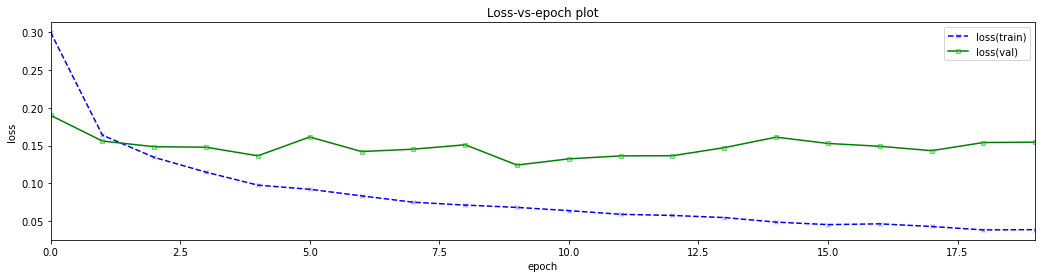

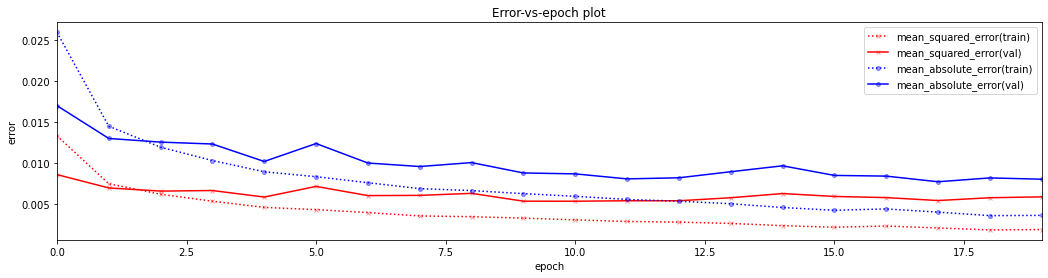

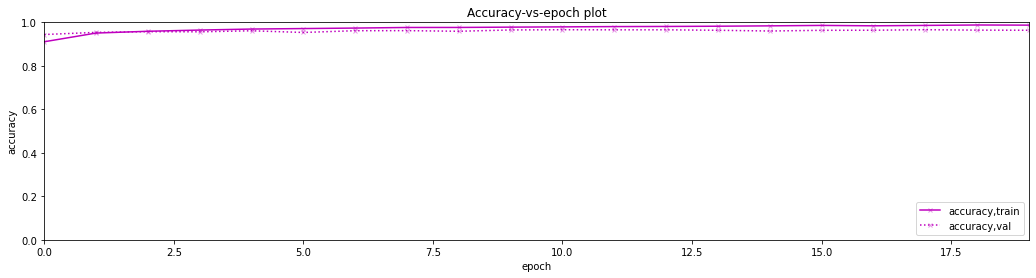


OK


In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

def MakePlots(history):
    N=3
    FX=60
    FY=4
    A=0.4
    S=4

    # Plot loss
    plt.figure(figsize=(FX, FY))
    ax = plt.subplot(1, N, 1)
    plt.plot(history.history["loss"]    , "b--x", markerfacecolor=(0, 0, 1, A), markersize=S)
    plt.plot(history.history["val_loss"], "g-s" , markerfacecolor=(0, 1, 0, A), markersize=S)
    plt.legend(loc="best", labels=("loss(train)","loss(val)"))
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.xlim((0, EPOCHS-1))
    plt.title("Loss-vs-epoch plot")
    plt.show()

    # Plot all metrics + loss
    plt.figure(figsize=(FX, FY))
    ax = plt.subplot(1, N, 2)
    plt.plot(history.history["mean_squared_error"],      "r:x", markerfacecolor=(1, 0, 0, A), markersize=S)
    plt.plot(history.history["val_mean_squared_error"],  "r-x", markerfacecolor=(1, 0, 0, A), markersize=S)
    plt.plot(history.history["mean_absolute_error"],     "b:o", markerfacecolor=(0, 0, 1, A), markersize=S)
    plt.plot(history.history["val_mean_absolute_error"], "b-o", markerfacecolor=(0, 0, 1, A), markersize=S)
    plt.xlabel("epoch")
    plt.ylabel("error")
    plt.xlim((0, EPOCHS-1))
    plt.legend(loc="best", labels=("mean_squared_error(train)",  "mean_squared_error(val)", 
                                   "mean_absolute_error(train)", "mean_absolute_error(val)"))
    plt.title("Error-vs-epoch plot")
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(FX, FY))
    ax = plt.subplot(1, N, 3)
    plt.plot(history.history["categorical_accuracy"],     "m-x", markerfacecolor=(1, 0, 1, A), markersize=S)
    plt.plot(history.history["val_categorical_accuracy"], "m:x", markerfacecolor=(1, 0, 1, A), markersize=S)
    ax.set_ylim([0,1])
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.xlim((0, EPOCHS-1))
    plt.legend(loc="lower right", labels=("accuracy,train","accuracy,val"))
    plt.title("Accuracy-vs-epoch plot")
    plt.show()

MakePlots(history)
print("\nOK")